<a href="https://colab.research.google.com/github/lucas6028/machine_learning/blob/main/Regression/medical_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [105]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

myseed = 198561  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)

## Download Data

In [106]:
# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

file_path = "/root/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1/insurance.csv"

Path to dataset files: /root/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1


## Some Utilities

In [107]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

## PreProcessing Data

In [108]:
# prompt: read from .csv file, split to train, validation, and test dataset

def load_and_split_data(file_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Loads a CSV file, splits it into train, validation, and test sets,
    and returns the corresponding DataFrames.

    Args:
        file_path (str): The path to the CSV file.
        train_ratio (float): The proportion of the data to include in the training set.
        val_ratio (float): The proportion of the data to include in the validation set.
        test_ratio (float): The proportion of the data to include in the test set.

    Returns:
        tuple: A tuple containing the training, validation, and test DataFrames.
    """

    df = pd.read_csv(file_path)

    # Split the data into train and temp sets
    train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42)

    # Split the temp data into validation and test sets
    val_size = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(temp_df, test_size=1 - val_size, random_state=42)

    return train_df, val_df, test_df

In [109]:
def preprocessing(df, target_only=False):
    # Missing values per column
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing / len(df)) * 100
    missing_data = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})
    print(missing_data[missing_data['Missing Values'] > 0])  # Only show columns with missing values

    # Checking Data Types and Converting Columns
    df['sex'] = pd.to_numeric(df['sex'].replace(to_replace='male', value=1), errors='coerce')
    df['sex'] = pd.to_numeric(df['sex'].replace(to_replace='female', value=-1), errors='coerce')
    df['smoker'] = pd.to_numeric(df['smoker'].replace(to_replace='yes', value=1), errors='coerce')
    df['smoker'] = pd.to_numeric(df['smoker'].replace(to_replace='no', value=0), errors='coerce')
    df['smoker'] = df['smoker'].fillna(0)
    df['sex'] = df['sex'].fillna(0)
    # df['region'] = df.to_numeric(df['region'], errors='coerce')
    df = one_hot_encode_sklearn(df, ['region'], 'charges')

    return df

In [110]:
def identify_dominant_columns(df, threshold=0.95):
    """
    Identifies columns where a single value appears more frequently than the specified threshold.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame to analyze
    threshold : float, optional (default=0.95)
        The threshold for considering a column dominant (between 0 and 1)

    Returns:
    --------
    dict
        A dictionary with column names as keys and their dominant value statistics as values
    """
    dominant_cols = {}

    for column in df.columns:
        # Calculate value counts and their proportions
        value_counts = df[column].value_counts(dropna=False)
        max_proportion = value_counts.iloc[0] / len(df)

        if max_proportion >= threshold:
            dominant_cols[column] = {
                'dominant_value': value_counts.index[0],
                'proportion': max_proportion,
                'count': value_counts.iloc[0],
                'total_rows': len(df)
            }

    return dominant_cols

In [111]:
def one_hot_encode_sklearn(df, features, target):
    """
    Function to apply one-hot encoding using sklearn's OneHotEncoder
    and ensure the target column is the last column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): A list of column names in the DataFrame to apply one-hot encoding.
    target (str): The name of the target column to place at the last column.

    Returns:
    pd.DataFrame: A DataFrame with the specified features one-hot encoded
                  and the target column at the last column.
    """
    # Initialize OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, drop=None)  # Use drop='first' to drop the first category if needed

    # Fit and transform only the specified features
    df_to_encode = df[features]

    # Perform one-hot encoding and return it as a DataFrame
    ohe_encoded = ohe.fit_transform(df_to_encode)

    # Create a DataFrame with encoded feature names
    encoded_columns = ohe.get_feature_names_out(features)
    df_encoded = pd.DataFrame(ohe_encoded, columns=encoded_columns, index=df.index)

    # Drop original features and concatenate the encoded features
    df_final = pd.concat([df.drop(features, axis=1), df_encoded], axis=1)

    # Ensure the target column is the last column
    if target in df_final.columns:
        # Move the target column to the end
        cols = [col for col in df_final.columns if col != target]
        cols.append(target)
        df_final = df_final[cols]

    return df_final

In [112]:
# Example usage:
train_df, val_df, test_df = load_and_split_data(file_path)

print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
print("Testing data shape:", test_df.shape)

train_df = preprocessing(train_df)
val_df = preprocessing(val_df)
test_df = preprocessing(test_df)

Training data shape: (936, 7)
Validation data shape: (201, 7)
Testing data shape: (201, 7)
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [113]:
# Missing values per column
missing = val_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(train_df)) * 100
missing_data = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})
missing_data[missing_data['Missing Values'] > 0]  # Only show columns with missing values

,Missing Values,Percentage


In [114]:
# identify_dominant_columns(train_df).keys()
train_df.dtypes

,0
age,int64
sex,float64
bmi,float64
children,int64
smoker,float64
region_northeast,float64
region_northwest,float64
region_southeast,float64
region_southwest,float64
charges,float64


## Dataset
- read `.csv` file
- extract features
- split into train / test sets
- normalize features

In [115]:
class MedicalCostDataset(Dataset):
  def __init__(self,
          df,
          mode='train',
          target_only=False):
      self.mode = mode
      # Convert DataFrame to numpy array
      data = df.values.astype(float)

      feats = list(range(10))

      if mode == 'test':
          # Testing data
          data = data[:, feats]
          self.data = torch.FloatTensor(data)
      else:
          # Training data (train/dev sets)
          target = data[:, -1]  # Last column is the target
          data = data[:, feats]

          # Splitting training data into train & dev sets
          if mode == 'train':
              indices = [i for i in range(len(data)) if i % 10 != 0]
          elif mode == 'dev':
              indices = [i for i in range(len(data)) if i % 10 == 0]

          # Convert data into PyTorch tensors
          self.data = torch.FloatTensor(data[indices])
          self.target = torch.FloatTensor(target[indices])

      # Normalize features (you may remove this part to see what will happen)
      self.data[:, 40:] = \
          (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
          / self.data[:, 40:].std(dim=0, keepdim=True)

      self.dim = self.data.shape[1]

      print('Finished reading the {} set of Medical Cost ({} samples found, each dim = {})'
            .format(mode, len(self.data), self.dim))

  def __getitem__(self, index):
      # Returns one sample at a time
      if self.mode in ['train', 'dev']:
          # For training
          return self.data[index], self.target[index]
      else:
          # For testing (no target)
          return self.data[index]

  def __len__(self):
      # Returns the size of the dataset
      return len(self.data)

## DataLoader

In [116]:
def prep_dataloader(df, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = MedicalCostDataset(df, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                # Construct dataloader
    return dataloader

## Deep Neural Network
NeuralNet is an nn.Module designed for regression. The DNN consists of 2 fully-connected layers with ReLU activation. This module also included a function cal_loss for calculating loss.

In [117]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, l1_lambda=0.0, l2_lambda=0.0):
        super(NeuralNet, self).__init__()

        # Define neural network here
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

        # Regularization parameters
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        # for i, layer in enumerate(self.net):
        #   x = layer(x)
        #   if torch.isnan(x).any():
        #       print(f"NaN found after layer {i}")
        #   if torch.isinf(x).any():
        #       print(f"Infinite values found after layer {i}")
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss with optional L1 and L2 regularization '''
        # Calculate the standard MSE loss
        mse_loss = self.criterion(pred, target)

        # L1 and L2 regularization terms
        l1_loss, l2_loss = 0.0, 0.0
        for param in self.net.parameters():
            if param.requires_grad:
                l1_loss += torch.sum(torch.abs(param))
                l2_loss += torch.sum(param ** 2)

        # Total loss with regularization
        total_loss = mse_loss + self.l1_lambda * l1_loss + self.l2_lambda * l2_loss
        return total_loss

## Train/Dev/Test

### Training

In [127]:

def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
      model.train()                        # set model to training mode
      for x, y in tr_set:                   # iterate through the dataloader
        # # Ensure input validity
        # x = torch.nan_to_num(x, nan=0.0, posinf=1e10, neginf=-1e10)
        # y = torch.nan_to_num(y, nan=0.0, posinf=1e10, neginf=-1e10)

        # # Forward pass
        # pred = model(x)

        # # Check for NaN in predictions
        # if torch.isnan(pred).any():
        #   print("NaN detected in predictions!")
        #   continue  # Skip this batch

        # # Compute loss
        # loss = model.cal_loss(pred, y)
        # if torch.isnan(loss).any():
        #   print("NaN detected in loss!")
        #   continue  # Skip this batch
        optimizer.zero_grad()                # set gradient to zero
        x, y = x.to(device), y.to(device)        # move data to device (cpu/cuda)
        pred = model(x)                  # forward pass (compute output)
        mse_loss = model.cal_loss(pred, y)        # compute loss
        mse_loss.backward()                 # compute gradient (backpropagation)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()                  # update model with optimizer
        loss_record['train'].append(mse_loss.detach().cpu().item())

      # After each epoch, test your model on the validation (development) set.
      dev_mse = dev(dv_set, model, device)
      if dev_mse < min_mse:
        # Save model if your model improved
        min_mse = dev_mse
        print('Saving model (epoch = {:4d}, loss = {:.4f})'
            .format(epoch + 1, min_mse))
        torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
        early_stop_cnt = 0
      else:
        early_stop_cnt += 1

      epoch += 1
      loss_record['dev'].append(dev_mse)
      if early_stop_cnt > config['early_stop']:
        # Stop training if your model stops improving for "config['early_stop']" epochs.
        break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

### Validation

In [119]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

### Testing

In [120]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

### Setup Hyper-parameters
`config`contains hypter-parameters for training and the path to save your model.

In [121]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 256,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.00001,                 # learning rate of SGD
        'momentum': 0.4             # momentum for SGD
    },
    'early_stop': 400,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

## Load Data and Model

In [122]:
tr_set = prep_dataloader(train_df, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(val_df, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(test_df, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of Medical Cost (842 samples found, each dim = 10)
Finished reading the dev set of Medical Cost (21 samples found, each dim = 10)
Finished reading the test set of Medical Cost (201 samples found, each dim = 10)


<ipython-input-115-8a83466f24a1>:34: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  / self.data[:, 40:].std(dim=0, keepdim=True)


In [123]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

## Start Training

In [128]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 68.0588)
Saving model (epoch =    4, loss = 67.4875)
Saving model (epoch =    5, loss = 64.9834)
Saving model (epoch =   12, loss = 63.8506)
Saving model (epoch =   55, loss = 63.6148)
Saving model (epoch =  267, loss = 63.1297)
Saving model (epoch =  435, loss = 62.7480)
Saving model (epoch =  611, loss = 62.3356)
Saving model (epoch =  627, loss = 62.2895)
Saving model (epoch =  671, loss = 62.0662)
Saving model (epoch =  683, loss = 61.9214)
Saving model (epoch =  925, loss = 60.9642)
Saving model (epoch = 1238, loss = 60.8666)
Saving model (epoch = 1312, loss = 60.8536)
Saving model (epoch = 1329, loss = 60.7751)
Saving model (epoch = 1440, loss = 59.8284)
Saving model (epoch = 1642, loss = 59.6076)
Saving model (epoch = 1737, loss = 59.0201)
Saving model (epoch = 1948, loss = 58.8897)
Saving model (epoch = 1972, loss = 58.8574)
Saving model (epoch = 2070, loss = 58.1523)
Saving model (epoch = 2371, loss = 57.8785)
Saving model (epoch = 2412, loss

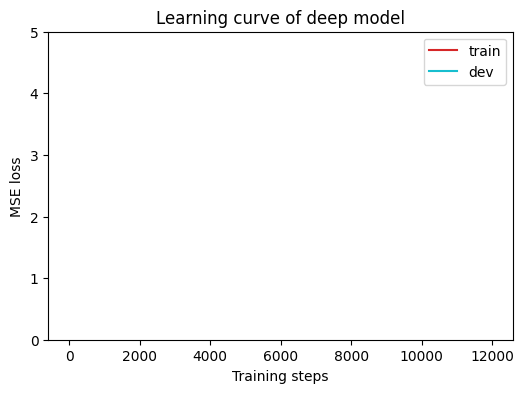

In [129]:
plot_learning_curve(model_loss_record, title='deep model')

<ipython-input-130-5bebdf951c03>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model


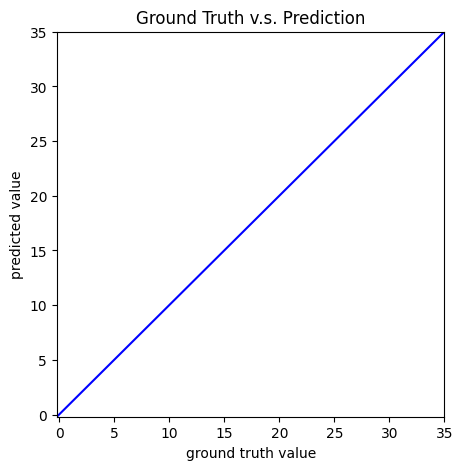

In [130]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set